## TNG Case Study - Optimization Problem Implementation
15.774/15.780 Recitation 6 <br>

In [7]:
import gurobipy as gp
from gurobipy import GRB

## Data

First let's look at the data. We have:
* `FleetSize`: The total # of trailers in TNG's fleet. 
* `Inventory_Start`: The # of trailers available in inventory at $t=1$
* `Price<i>[t]`: The *daily* rate for a lease of type $i$ in period $t$
* `Demand<i>[t]`: The true demand for least of type $i$ in period $t$
* `OldReturn<i>[t]`: The # of leases of type $i$ (accepted before $t=1$) being returned in period $t$
* `TNG_Accept<i>[t]`: TNG's decision of how many leases of type $i$ they accepted in period $t$
* `TotalInDemand[t]` (calculated): # of trailers in demand in period $t$
    * This is just counting *if we had accepted every lease offer*, how many trucks would be out in period $t$. 
    
Typically this would be in a dataframe, but we've already put it in vectors. `.py` files contain Python code (in this case just hard-coded vectors), and `from <some script> import *` will run that code (so populate the vectors). 

In [8]:
from TNG_data import *
print(Price1[0:10])

[26.  29.  30.5 27.5 29.  27.5 27.5 29.  35.  35. ]


Let's build a little utility function first to compute revenue for a set of decisions. Recall that what our model will tell us is how many leases of type $i$ we should accept in period $t$. So to get the revenue, we just need to sum the revenues from every lease in every period according to it's daily rate.

$$ \sum_{t=1}^{50} 7 \cdot P_{1,t} \cdot X_{1,t} + 7 \cdot 4 \cdot P_{4,t} \cdot X_{4,t} + 7 \cdot 8 \cdot P_{8,t} \cdot X_{8,t} + 7 \cdot 16 \cdot P_{16,t} \cdot X_{16,t}$$

There's one little wrinkle. Our model will actually need to be based on forecasted demand, since in practice we don't know the true demand that will arise in the future. So if our model tells us to accept 30 leases in period $t$ because the forecast was that we need 35, but in reality demand was 25, we will only be able to give 25 leases.

So here's the function:


In [9]:
def compute_revenue(Acc1, Acc4, Acc8, Acc16):
    # Point-wises (for every period) minimum of demand and what the model tells us to accept.
    ActualAcc1  = np.minimum(Acc1,  Demand1)
    ActualAcc4  = np.minimum(Acc4,  Demand4)
    ActualAcc8  = np.minimum(Acc8,  Demand8)
    ActualAcc16 = np.minimum(Acc16, Demand16)
    
    # Point-wise revenue from leases accepted in each period, then sum 
    rev = sum(7   * Price1  * ActualAcc1 + 
              28  * Price4  * ActualAcc4 + 
              56  * Price8  * ActualAcc8 + 
              112 * Price16 * ActualAcc16)
    
    return round(rev / 1000) # In thousand $

In [23]:
# Let's compute the revenue of TNG's actual decisions:
print("TNG Actual Decision Revenue:", compute_revenue(TNG_Accept1, TNG_Accept4, TNG_Accept8, TNG_Accept16))

TNG Actual Decision Revenue: 4707


## TNG Function
To make our life easier, let's wrap the model building into a function. This will take forecasted demand, formulate the `gurobipy` model, solve it, and give back the optimal solutions. 

Input is 4 vectors (`D1`, `D4`, `D8`, `D16`), each of length 50, denoting our forecasted demand for each type of lease in each period. 

In [25]:
# Define our function
def solve_TNG(D1, D4, D8, D16):

    # Set up environment
    env = gp.Env(empty=True)
    env.setParam('OutputFlag', 0)
    env.start()
    
    # Initialize the model
    m = gp.Model(env=env)
    
    ######################################## DEFINE VARIABLES ########################################

    # Decision variables: How many leases to accept of type i in period t
    # Constraint: Cannot accept more than demand
    Accept1  = m.addVars(50, lb=0, ub=(D1[t] for t in range(0,50)), name="Accept1")
    Accept4  = m.addVars(50, lb=0, ub=(D4[t] for t in range(0,50)), name="Accept4")
    Accept8  = m.addVars(50, lb=0, ub=(D8[t] for t in range(0,50)), name="Accept8")
    Accept16 = m.addVars(50, lb=0, ub=(D16[t] for t in range(0,50)), name="Accept16")

    ######################################## INVENTORY RETURNS ########################################
    # Auxiliary variables: How many trailer of type i were returned in period t
    Return1  = m.addVars(50, lb=0, name="Return1")
    Return4  = m.addVars(50, lb=0, name="Return4")
    Return8  = m.addVars(50, lb=0, name="Return8")
    Return16 = m.addVars(50, lb=0, name="Return16")
    
    # Constraints: First few weeks, returns were the trailers leased before t = 1 (get them from OldReturns).
    #             After, its just whatever leases we accepted the right amount of periods ago.
    
    m.addConstr(Return1[0] == OldReturn1[0])
    m.addConstrs(Return1[t] == Accept1[t-1] for t in range(1,50))

    m.addConstrs(Return4[t] == OldReturn4[t] for t in range(0,4))
    m.addConstrs(Return4[t] == Accept4[t-4] for t in range(4,50))
    
    m.addConstrs(Return8[t] == OldReturn8[t] for t in range(0,8))
    m.addConstrs(Return8[t] == Accept8[t-8] for t in range(8,50))    

    m.addConstrs(Return16[t] == OldReturn16[t] for t in range(0,16))
    m.addConstrs(Return16[t] == Accept16[t-16] for t in range(16,50))


    ######################################## INVENTORY ########################################
    # Auxiliary variables: available inventory at the beginning of period t

    Inventory = m.addVars(50, lb=0, name="Inventory")
    
    # Constraint: (Inventory now) = (Inventory last period) - (Accepted last period) + (Returned this period)

    m.addConstr(Inventory[0] == Inventory_Start +
                                Return1[0] + Return4[0] + Return8[0] + Return16[0])

    m.addConstrs(Inventory[t] == Inventory[t-1] 
                                 - Accept1[t-1] - Accept4[t-1] - Accept8[t-1] - Accept16[t-1] 
                                 + Return1[t]   + Return4[t]   + Return8[t]   + Return16[t]
                                 for t in range (1,50))
    
    # Constraint: Cannot accept more leases than inventory in period t
    InvConst = m.addConstrs((Accept1[t] + Accept4[t] + Accept8[t] + Accept16[t] <= Inventory[t]
                 for t in range(0,50)))


    ######################################## OBJECTIVE ########################################
    # Maximize revenue (note that Price<i> is daily rate)
    m.setObjective(sum(7 * 1  * Price1[t]  * Accept1[t] + 
                       7 * 4  * Price4[t]  * Accept4[t] + 
                       7 * 8  * Price8[t]  * Accept8[t] + 
                       7 * 16 * Price16[t] * Accept16[t] for t in range(0,50)),
                  GRB.MAXIMIZE
                  )



    ######################################## OPTIMIZE AND FIND SOLUTION ########################################
    m.update() # Update model parameters
    m.write("TNG.lp") # Write model to file
    
    m.optimize()
    
    # Extract optimal acceptance decisions
    OptAccept1 = m.getAttr('x', Accept1).values()
    OptAccept4 = m.getAttr('x', Accept4).values()
    OptAccept8 = m.getAttr('x', Accept8).values()
    OptAccept16 = m.getAttr('x', Accept16).values()
    OptAccept1 = np.array(list(OptAccept1))
    OptAccept4 = np.array(list(OptAccept4))
    OptAccept8 = np.array(list(OptAccept8))
    OptAccept16 = np.array(list(OptAccept16))

    # Get shadow prices for inventory constraint. 
    InventShadow = m.getAttr('Pi', InvConst).values()
   
    # Return vector of acceptances, objective value:
    return OptAccept1, OptAccept4, OptAccept8, OptAccept16, InventShadow

## Optimizing with known demand
As a first pass, let's assume we perfectly know future demand (i.e. our forecasts are the true demand). 

Of course, this is not realistic. But it provides an upper bound on how well we can do. 

In [26]:
Acc1, Acc4, Acc8, Acc16, sp = solve_TNG(Demand1, Demand4, Demand8, Demand16);
print("Optimization with known demand Revenue:", compute_revenue(Acc1, Acc4, Acc8, Acc16))

Optimization with known demand Revenue: 4918


We can use the `PyPlot` package to make some basic plots. For example, let's see how the optimization's 1-week lease decisions compare to TNG:

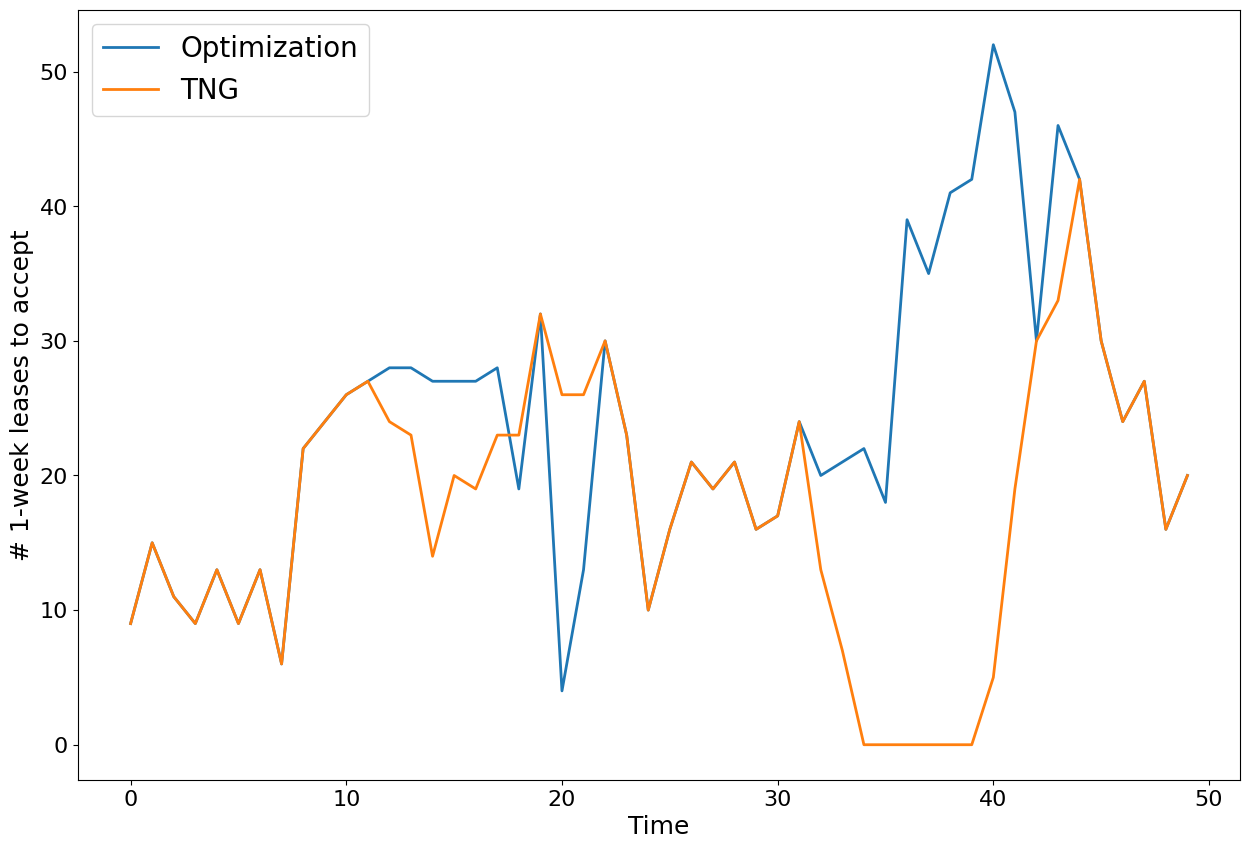

In [13]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'figure.figsize': [15, 10],
    'font.size': 20,
    'axes.titlesize' : 20,
    'axes.labelsize' : 18,
    'lines.linewidth' : 2,
    'lines.markersize' : 10,
    'xtick.labelsize' : 16,
    'ytick.labelsize' : 16
})
plt.plot([*range(0,50)], Acc1)
plt.plot([*range(0,50)], TNG_Accept1)
plt.legend(["Optimization", "TNG"])
plt.xlabel("Time")
plt.ylabel("# 1-week leases to accept");
plt.show()

More interestingly, let's plot the inventory shadow prices over time:

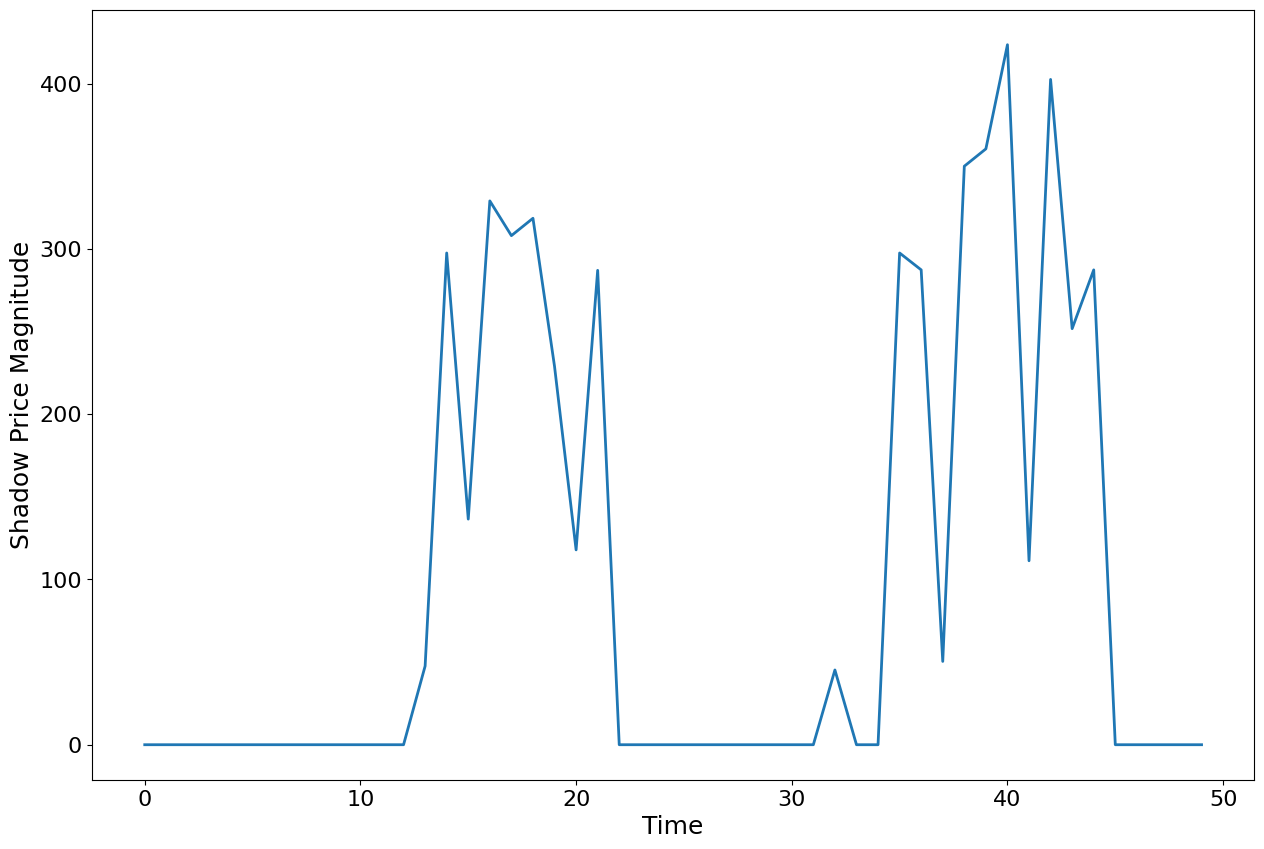

In [14]:
plt.plot([*range(0,50)], sp)
plt.xlabel("Time")
plt.ylabel("Shadow Price Magnitude");

Now let's see how they relate to the total demand:

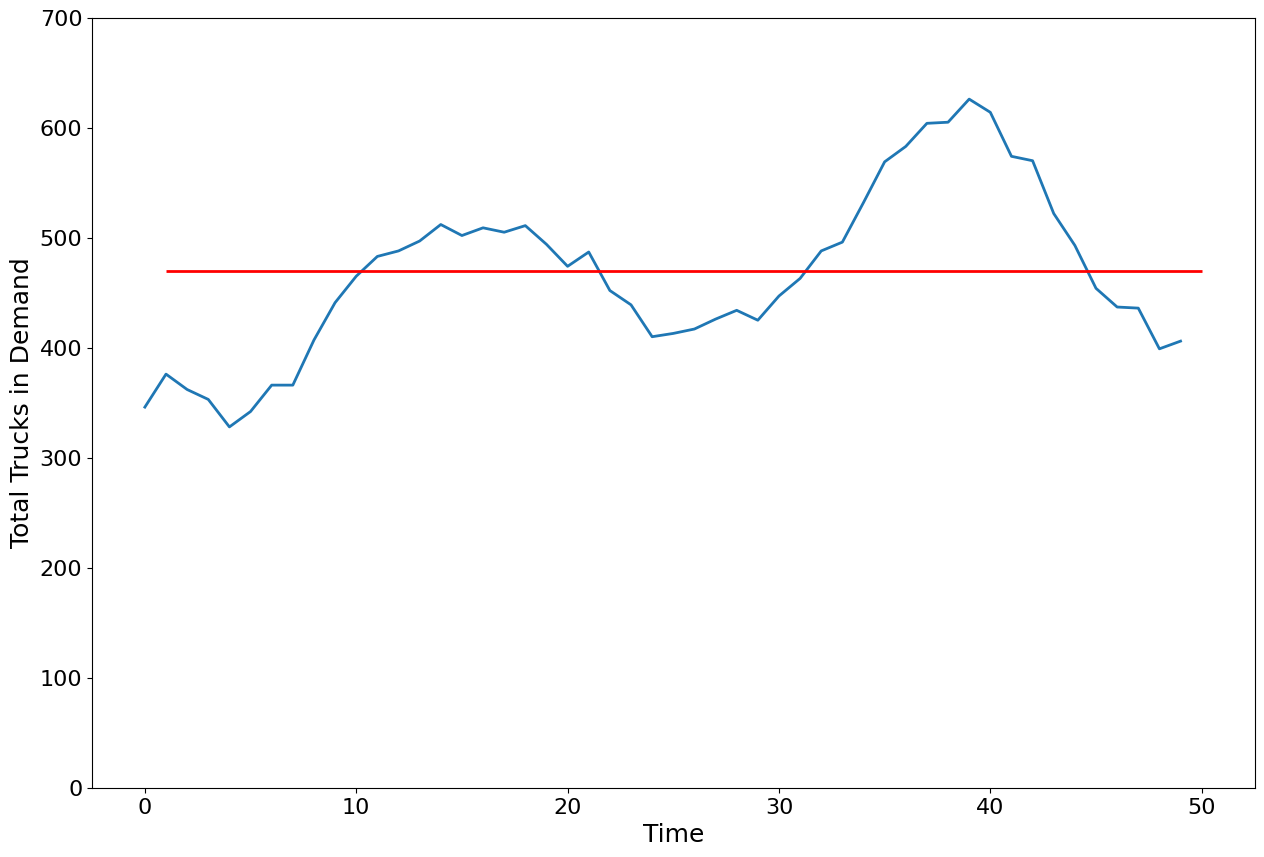

In [15]:
plt.plot([*range(0,50)], TotalInDemand)
plt.hlines(FleetSize, xmin=1, xmax=50, color="red")
plt.ylim(0, 700)
plt.xlabel("Time")
plt.ylabel("Total Trucks in Demand");

This makes sense! The shadow prices are high whenever we don't have enough fleet to satisfy demand. That's when having one extra unit of inventory would improve our revenue.

## Imperfect demand

As we said, the above model is an upper bound on how well we can do. In reality, we only have demand forecasts, so our model might be off (tell us to accept more than actually came in, or accept too few because it didn't as much as came in). 

So let's use some randomness to create fake forecasts. We will just randomly add some $\pm 1$ to the true demand and pretend that this is what we would have forecasted. 

In [28]:
np.random.seed(15)
Forecast1  = Demand1  + np.random.uniform(low=-1, high=1, size=50)
Forecast4  = Demand4  + np.random.uniform(low=-1, high=1, size=50)
Forecast8  = Demand8  + np.random.uniform(low=-1, high=1, size=50)
Forecast16 = Demand16 + np.random.uniform(low=-1, high=1, size=50)

FAcc1, FAcc4, FAcc8, FAcc16, Fsp = solve_TNG(Forecast1, Forecast4, Forecast8, Forecast16);

print("Optimization with predicted demand Revenue:", compute_revenue(FAcc1, FAcc4, FAcc8, FAcc16))

Optimization with predicted demand Revenue: 4833


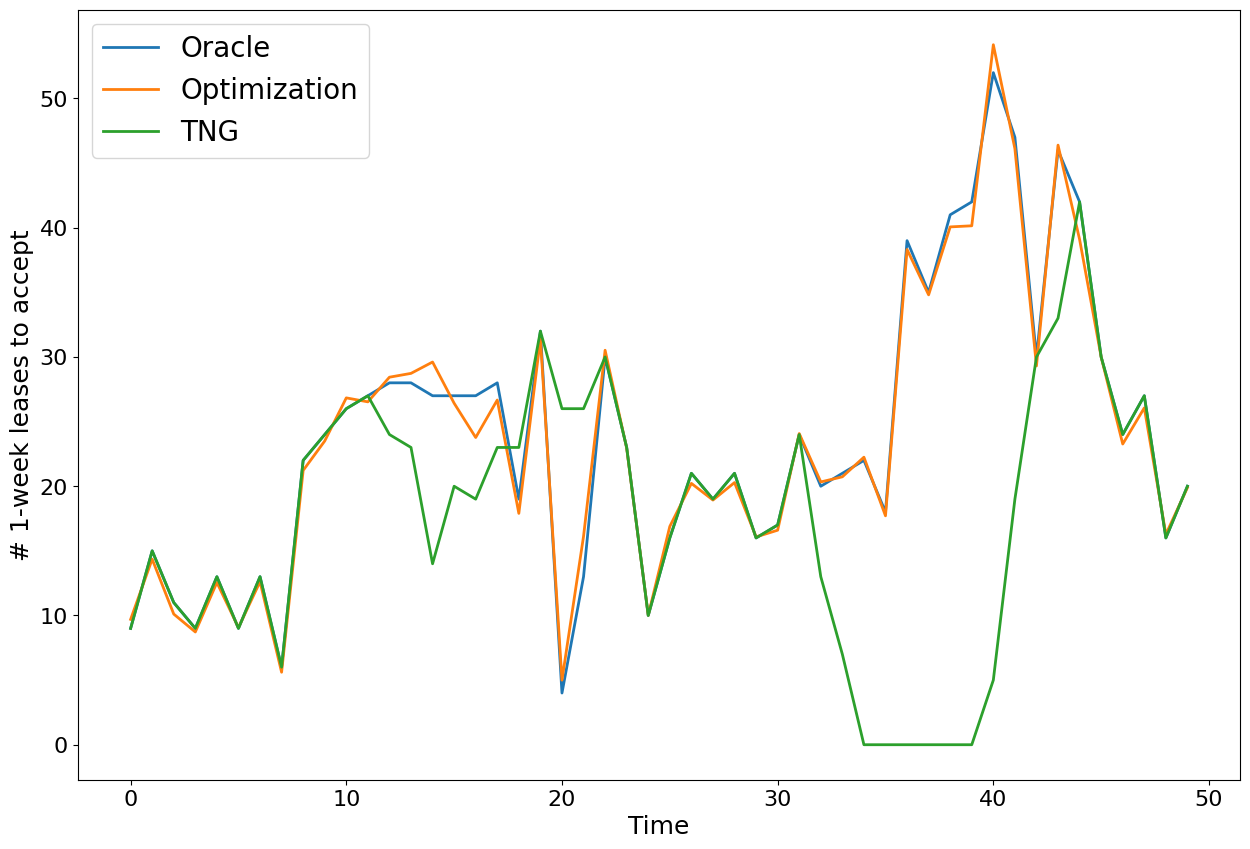

In [ ]:
plt.plot([*range(0,50)], Acc1) # from optimization with known demand!
plt.plot([*range(0,50)], FAcc1) # from optimization with predicted demand!
plt.plot([*range(0,50)], TNG_Accept1) # TNG's actual decisions!
plt.legend(["Oracle", "Optimization", "TNG"])
plt.xlabel("Time")
plt.ylabel("# 1-week leases to accept");